# Módulo 3 - Modelado

## Librerías

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests
import zipfile
from io import BytesIO
import matplotlib.pyplot as plt

In [2]:
# Get cpu, gpu or mps device for training.
device = (
   "cuda"
   if torch.cuda.is_available()
   else "mps"
   if torch.backends.mps.is_available()
   else "cpu"
)

# device = "cpu"

print(f"Usando como dispositivo {device}")

Usando como dispositivo cpu


/home/druiz35/Documents/SEpsilon/SEpsilon-Proyectos/AI-ML-Data/RNABI2025-1-Equipo3/Trabajo3/notebooks/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Cargado de datos

In [3]:
df = pd.read_csv("m3_merged_df.csv")
user_item_df = df[["UserID", "DestinationID_x", "Rating"]]
user_item_df.columns = ["user", "item", "rating"]
user_item_df

,user,item,rating
0,327,178,2
1,783,411,1
2,959,358,3
3,353,989,2
4,408,473,4
...,...,...,...
988,850,701,3
989,850,701,3
990,346,231,5
991,346,231,5


In [4]:
user_item_df["user"].value_counts

<bound method IndexOpsMixin.value_counts of 0      327
1      783
2      959
3      353
4      408
      ... 
988    850
989    850
990    346
991    346
992    858
Name: user, Length: 993, dtype: int64>

## Crear matriz de usuario-item

In [5]:
def create_user_item_matrix(df):
    #n_users = df['user'].nunique()
    #n_items = df['item'].nunique()
    #print(n_users, n_items)

    # Adjust for 0-based indexing
    df['user'] = df['user'] - 1
    df['item'] = df['item'] - 1

    n_rows = max(df['user'].to_list())
    n_cols = max(df['item'].to_list())
    print(f"MATRIX DIMENSIONS: {n_rows, n_cols}")
    user_item_matrix = torch.zeros((n_rows, n_cols))
    for _, row in df.iterrows():
        print(row["user"], row["item"])
        user_item_matrix[row['user']-1, row['item']-1] = row['rating']

    return user_item_matrix

user_item_matrix = create_user_item_matrix(user_item_df)
user_item_matrix

/tmp/ipykernel_125453/1311194605.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user'] = df['user'] - 1
/tmp/ipykernel_125453/1311194605.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['item'] = df['item'] - 1


MATRIX DIMENSIONS: (998, 999)
326 177
782 410
958 357
352 988
407 472
734 976
329 697
108 918
385 252
812 304
625 299
19 433
19 433
553 415
553 415
68 848
68 848
29 511
590 965
590 965
453 673
453 673
981 55
355 159
355 159
321 55
321 55
331 514
978 779
636 381
636 381
871 23
559 389
559 389
559 389
550 203
132 83
496 710
496 710
500 398
538 56
538 56
534 762
534 762
654 840
479 151
479 151
487 522
210 315
874 955
320 664
320 664
902 502
498 203
553 32
553 32
134 915
134 915
850 364
850 364
850 364
571 516
571 516
571 516
102 304
667 930
568 350
739 180
988 816
988 816
111 372
683 22
683 22
683 22
547 139
339 589
574 145
574 145
181 938
358 506
358 506
358 506
861 742
861 742
756 866
756 866
756 866
627 225
627 225
224 303
537 233
537 233
589 13
699 670
562 960
936 342
567 959
943 916
943 916
943 916
943 916
211 554
396 647
98 102
473 714
473 714
473 714
241 294
1 706
1 706
42 159
445 968
445 968
898 345
414 485
217 708
217 708
127 205
939 279
681 502
804 92
850 982
850 982
850 982
508

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [6]:
total_entries = user_item_matrix.numel()
print(f"El total de entradas de la matriz es: {total_entries}")

zero_entries = (user_item_matrix == 0).sum().item()
print(f"El porcentaje de entradas nulas es la matriz es: {zero_entries/total_entries*100:0.2f}%")


El total de entradas de la matriz es: 997002
El porcentaje de entradas nulas es la matriz es: 99.94%


## Creación de clase Dataset para Torch

In [7]:
class UserDestinationDataset(Dataset):
    def __init__(self, user_item_matrix):
        self.user_item_pairs = [(u, i) for u in range(user_item_matrix.shape[0])
                                for i in range(user_item_matrix.shape[1])
                                if user_item_matrix[u, i] != 0] # contiene las combinaciones no nulas (user, item)
        self.labels = [user_item_matrix[u, i] for u, i in self.user_item_pairs] # extrae las calificaciones para las combinaciones no nulas (user, item)
        self.n_users = user_item_matrix.shape[0]
        self.n_items = user_item_matrix.shape[1]

    def __len__(self):
        return len(self.user_item_pairs)

    def __getitem__(self, idx):
        return self.user_item_pairs[idx], self.labels[idx]


In [8]:
dataset = UserDestinationDataset(user_item_matrix)

### Tamaño del dataset

In [9]:
print(f"El tamaño del dataset es de {len(dataset)} elmentos")

El tamaño del dataset es de 648 elmentos


## Creación de clase NCF

In [10]:
class NCF(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim, layers):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        self.fc_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i+1]))

        self.output_layer = nn.Linear(layers[-1], 1)
        self.activation = nn.ReLU()

    def forward(self, user_input, item_input):
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        x = torch.cat([user_embedded, item_embedded], dim=-1)

        for layer in self.fc_layers:
            x = self.activation(layer(x))

        output = self.output_layer(x)
        return output.squeeze()


## Definición de hiperparámetros

In [11]:
embedding_dim = 64
layers = [embedding_dim*2, 128, 64, 32]
lr = 0.001
batch_size = 256
n_epochs = 50

## Creación de DataLoader

In [12]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Inicialización del modelo

In [13]:
model = NCF(dataset.n_users, dataset.n_items, embedding_dim, layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

### Cantidad de parámetros del modelo

In [14]:
num_par = sum(p.numel() for p in model.parameters () if p.requires_grad)

print(f"El modelo tiene {num_par} parámetros")

El modelo tiene 154689 parámetros


## Entrenamiento del modelo

In [15]:
history = []
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for (user, item), label in dataloader:
        optimizer.zero_grad()
        output = model(user, item)
        loss = criterion(output, label.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    history.append(total_loss/len(dataloader))

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(dataloader):.4f}")


Epoch 1/50, Loss: 11.6092
Epoch 2/50, Loss: 10.9869
Epoch 3/50, Loss: 10.4541
Epoch 4/50, Loss: 9.7700
Epoch 5/50, Loss: 8.8620
Epoch 6/50, Loss: 7.5033
Epoch 7/50, Loss: 6.0575
Epoch 8/50, Loss: 4.5414
Epoch 9/50, Loss: 3.0550
Epoch 10/50, Loss: 2.1076
Epoch 11/50, Loss: 2.0326
Epoch 12/50, Loss: 2.2193
Epoch 13/50, Loss: 2.0913
Epoch 14/50, Loss: 1.6635
Epoch 15/50, Loss: 1.3889
Epoch 16/50, Loss: 1.3269
Epoch 17/50, Loss: 1.3312
Epoch 18/50, Loss: 1.3153
Epoch 19/50, Loss: 1.1641
Epoch 20/50, Loss: 1.0584
Epoch 21/50, Loss: 0.9736
Epoch 22/50, Loss: 0.9675
Epoch 23/50, Loss: 0.9259
Epoch 24/50, Loss: 0.8346
Epoch 25/50, Loss: 0.8055
Epoch 26/50, Loss: 0.7688
Epoch 27/50, Loss: 0.7299
Epoch 28/50, Loss: 0.6824
Epoch 29/50, Loss: 0.6452
Epoch 30/50, Loss: 0.6091
Epoch 31/50, Loss: 0.5670
Epoch 32/50, Loss: 0.5590
Epoch 33/50, Loss: 0.5222
Epoch 34/50, Loss: 0.4871
Epoch 35/50, Loss: 0.4697
Epoch 36/50, Loss: 0.4323
Epoch 37/50, Loss: 0.4059
Epoch 38/50, Loss: 0.4026
Epoch 39/50, Loss:

## Uso del modelo

### Prueba básica

In [16]:
def predict(user_id, item_id):
    model.eval()
    user = torch.tensor([user_id])
    item = torch.tensor([item_id])
    with torch.no_grad():
        prediction = model(user, item).item()
    return int(prediction)

In [17]:
id_user = 920
id_item = 273
prediction = predict(id_user, id_item)
print(f"Predicted rating for user {id_user} and item {id_item}: {prediction}")




Predicted rating for user 920 and item 273: 2


### Prueba 1 usuario X múltiples items

In [18]:
# Elementos nulos (no se cuenta con una valoración):
zero_indices = (user_item_matrix == 0).nonzero()
print(zero_indices)

tensor([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [997, 996],
        [997, 997],
        [997, 998]])


In [19]:
with torch.no_grad():
  model.eval()
  for i in range(100):
    user = zero_indices[i][0]
    item = zero_indices[i][1]
    prediction = model(user, item)
    print(f"Predicted rating for user {user} and item {item}: {prediction.item():.2f}")

Predicted rating for user 0 and item 0: 4.65
Predicted rating for user 0 and item 1: 4.63
Predicted rating for user 0 and item 2: 4.82
Predicted rating for user 0 and item 3: 3.70
Predicted rating for user 0 and item 4: 3.73
Predicted rating for user 0 and item 5: 4.61
Predicted rating for user 0 and item 6: 4.04
Predicted rating for user 0 and item 7: 3.98
Predicted rating for user 0 and item 8: 4.49
Predicted rating for user 0 and item 9: 4.61
Predicted rating for user 0 and item 10: 2.65
Predicted rating for user 0 and item 11: 3.42
Predicted rating for user 0 and item 12: 2.85
Predicted rating for user 0 and item 13: 4.97
Predicted rating for user 0 and item 14: 4.03
Predicted rating for user 0 and item 15: 3.78
Predicted rating for user 0 and item 16: 3.97
Predicted rating for user 0 and item 17: 4.17
Predicted rating for user 0 and item 18: 3.39
Predicted rating for user 0 and item 19: 3.71
Predicted rating for user 0 and item 20: 3.30
Predicted rating for user 0 and item 21: 4.0

## Visualización de la función de pérdida

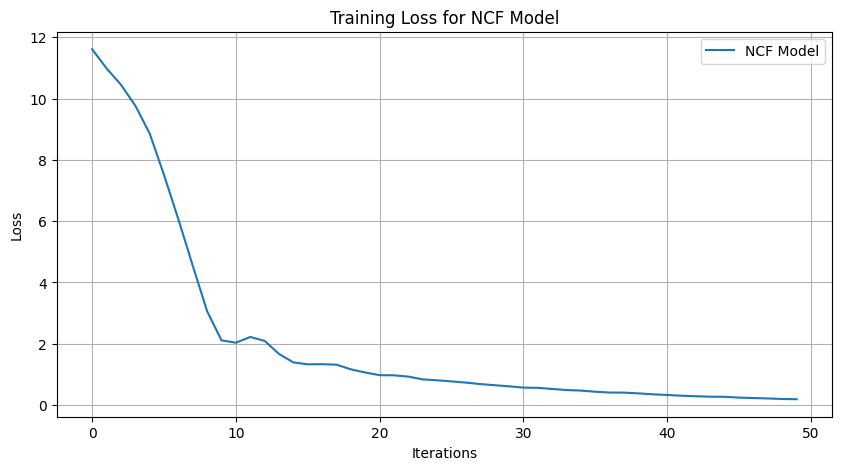

In [20]:
# Plot history
plt.figure(figsize=(10, 5))
plt.plot(history, label='NCF Model')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss for NCF Model')
plt.legend()
plt.grid()
plt.show() 

In [21]:
user_ids = user_item_df["user"].unique()
item_ids = user_item_df["item"].unique()
print(user_ids)


[326 782 958 352 407 734 329 108 385 812 625  19 553  68  29 590 453 981
 355 321 331 978 636 871 559 550 132 496 500 538 534 654 479 487 210 874
 320 902 498 134 850 571 102 667 568 739 988 111 683 547 339 574 181 358
 861 756 627 224 537 589 699 562 936 567 943 211 396  98 473 241   1  42
 445 898 414 217 127 939 681 804 508 527 206  53 168 763 918 611 702 581
  33 588 942 489 477 638 707 523 595 584 398 751 337 991 325 122 332 735
 261  90 239 123 363 465 390 532 273 797 100 502 362  70 555 673 113 948
 785 418  75 335 940 543 447 813 563 501 259 474 126 776 710 873  28 420
 799 986 662 483 116 238 870 732 255 661 284 768 833  80  99 199 372 180
 998 315 826 854 802 451 742 652 930 837 728 791 280  87 545 781 972 780
 915 515  94 364 619 314 698 179 433   4 296 566 578 777 903 672 309 495
 232  72 658 229 258 564  78 366 164 215 717 190 933 173 304 287 475 693
 221 497 377 744 960 282 322 800 183 103 290 889 106 670 628 267 536  14
 359  25 214 147 969 472 462 851 430 634 949 272 75

In [22]:
print(item_ids)

[177 410 357 988 472 976 697 918 252 304 299 433 415 848 511 965 673  55
 159 514 779 381  23 389 203  83 710 398  56 762 840 151 522 315 955 664
 502  32 915 364 516 930 350 180 816 372  22 139 589 145 938 506 742 866
 225 303 233  13 670 960 342 959 916 554 647 102 714 294 706 968 345 485
 708 205 279  92 982   8   1 541 209 301 208 699  46 530 863 952 958 355
 883 885 701 517  89 795 404 316 769 425 595 290 491 117 805 385 447 721
 871 749 276 761 236 969 115 854  69 243 663 766 292 213 951 792 597 635
 640 483 475 120 499 181 994 368 649 961  33 760 718  12 143 179 414 612
 378 256 344 190 914 598 150 435 428 874 527 583  62 129 591 267 634 441
 908 461 217 665 547 281 869 692 977 467 513  59 877 954 293 490 477 399
 519 684 165 408  34 719 843  24 904  19 170 187 999 658 222 395 501 791
 207 820 603 175 917 275 775 745 676 343 700  51 826 373 112 122 194 450
 607 353 140 383   7 906 717 456 912 358 107 457 470 897 741  79 478 240
 164 500 823 537 462 713 523 224 135 794 314 633 32

In [23]:
id_user = 325
id_item = 104
prediction = predict(id_user, id_item)
print(f"Predicted rating for user {id_user} and item {id_item}: {prediction}")


Predicted rating for user 325 and item 104: 1


In [24]:
coso = user_item_df[(user_item_df["user"] == id_user) & (user_item_df["item"] == id_item)]
len(coso)

0

In [25]:
import itertools
user_item_pairs = list(itertools.product(user_ids, item_ids))

print(user_item_pairs[:20])

[(326, 177), (326, 410), (326, 357), (326, 988), (326, 472), (326, 976), (326, 697), (326, 918), (326, 252), (326, 304), (326, 299), (326, 433), (326, 415), (326, 848), (326, 511), (326, 965), (326, 673), (326, 55), (326, 159), (326, 514)]


In [29]:
error_accum = 0
N = 0
for pair in user_item_pairs:
    user_df = user_item_df[(user_item_df["user"] == pair[0]) & (user_item_df["item"] == pair[1])]
    if len(user_df) > 0:
        try: 
            real_ratings = user_df["rating"].values
            for real_rating in real_ratings:
                prediction = predict(pair[0], pair[1])
                error_accum += (prediction - real_rating)**2
                N += 1
        except: 
            print("Failed!")


Failed!
Failed!


In [30]:
RMSE = (error_accum/N)**0.5
RMSE

1.764693008469579